### 0. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [ ]:
!pip install nltk

In [1]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import re

# visualizacion de resultados
import seaborn as sns   
from matplotlib import pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import GridSearchCV, train_test_split

# modelos 
from sklearn import tree, svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Para evaluar el modelo
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score 

import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

# Carga de los datos
A través de la librería **pandas** podemos realizar la carga de datos desde diferentes fuentes de información, en este caso se realizará la carga de un archivo plano csv, mque contiene la informacion de los sentimientos relacionados con un tweet

## Dataset tweets

In [3]:
# Se cargan los datos. 
df_tweets=pd.read_csv('./data/mbsa.csv', sep=',', encoding = 'utf-8', header=0)

In [4]:
# Cantidad de datos y número de variables
df_tweets.shape

(19344048, 3)

In [5]:
# Mostrar los datos
df_tweets.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [6]:
# Podemos ver los tipos de todas la variables.
df_tweets.dtypes

Date         object
text         object
Sentiment    object
dtype: object

In [7]:
df_tweets["Sentiment"].value_counts()

Negative    9729297
Positive    8723207
Neutral         400
Name: Sentiment, dtype: int64

## Dataset Precios Bitcoin
dado que hay muy pocas muestras nuetrales, decidimos usar el dataset de precios de bitcoin para poder definir cuando hay un cambio positivo, cuando negativo y cuando neutral

In [8]:
# Se cargan los datos. 
df_precios=pd.read_csv('./data/coin_Bitcoin.csv', sep=',', encoding = 'utf-8', header=0)

In [9]:
# Cantidad de datos y número de variables
df_precios.shape

(2991, 10)

In [10]:
# Mostrar los datos
df_precios.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [11]:
# Podemos ver los tipos de todas la variables.
df_precios.dtypes

SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

# Limpieza y preparación de los datos

Primero vamos a ejecutar los pasos de limpieza de los datos, relacionados el tratamiento de ausencias y registros duplicados.

## Tweets

In [12]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
df_tweets_l = df_tweets

In [13]:
# Se observa la cantidad de ausencias en los datos
df_tweets_l.isnull().sum()

Date              0
text             16
Sentiment    891144
dtype: int64

In [14]:
# Eliminación registros con ausencias
df_tweets_l = df_tweets_l.dropna()
# Eliminación de registros duplicados.
df_tweets_l = df_tweets_l.drop_duplicates()

In [15]:
# Cantidad de datos y número de variables
df_tweets_l.shape

(15803216, 3)

In [16]:
df_tweets_l["Sentiment"].value_counts()

Negative    8013795
Positive    7789126
Neutral         295
Name: Sentiment, dtype: int64

In [17]:
# Se realiza un procesamiento sobre el campo de la fecha, para que esta se encuentre en el formato correcto
df_tweets_l["Date"]=pd.to_datetime(df_tweets_l["Date"], format='%Y-%m-%d', errors='coerce')

In [18]:
df_tweets_l["Date"].describe()

count                15803216
unique                   1893
top       2019-07-26 00:00:00
freq                   174149
first     2014-09-18 00:00:00
last      2019-11-23 00:00:00
Name: Date, dtype: object

## Precios

In [19]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
df_precios_l = df_precios

In [20]:
# Se observa la cantidad de ausencias en los datos
df_precios_l.isnull().sum()

SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

In [21]:
# Se realiza un procesamiento sobre el campo de la fecha, para que esta se encuentre en el formato correcto
df_precios_l["Date"]=pd.to_datetime(df_precios_l["Date"], format='%Y-%m-%d', errors='coerce').dt.date
df_precios_l["Date"]=pd.to_datetime(df_precios_l["Date"], format='%Y-%m-%d', errors='coerce')

In [22]:
df_precios_l["Date"].describe()

count                    2991
unique                   2991
top       2013-04-29 00:00:00
freq                        1
first     2013-04-29 00:00:00
last      2021-07-06 00:00:00
Name: Date, dtype: object

In [23]:
# Se calcula la variación del día
df_precios_l["Variacion"]= df_precios_l["Close"]-df_precios_l["Open"]

In [24]:
# Se eliminan las columnas que no son de interes para el modelo
df_precios_l.drop(["SNo", "Name", "Symbol", "High", "Low", "Open", "Close", "Volume", "Marketcap"], axis=1,inplace=True)

In [25]:
df_precios_l.dtypes

Date         datetime64[ns]
Variacion           float64
dtype: object

## Union de datasets

Ahora para la construcción de los datos de entrada se unen los 2 dataset utilizados con el objetivo de tener 3 muestras una para los tweets con efecto positivo otro con los tweets de efecto negativo, y finalmente una categoria con los tweets que no tuvieron influencia

In [26]:
df_datos=df_tweets_l.merge(df_precios_l, left_on='Date', right_on='Date', how="left")

In [27]:
df_datos.head()

,Date,text,Sentiment,Variacion
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive,131.705973
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive,131.705973
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive,131.705973
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive,131.705973
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive,131.705973


In [28]:
df_datos.describe()

,Variacion
count,1.580322e+07
mean,2.291744e+00
std,4.522762e+02
min,-2.345600e+03
25%,-1.763449e+02
50%,9.329834e-01
75%,1.896414e+02
max,3.633600e+03


In [29]:
percentile_positive=df_datos["Variacion"].quantile(0.66)
percentile_negative=df_datos["Variacion"].quantile(0.33)

In [30]:
df_datos.loc[df_datos["Variacion"]>percentile_positive, "Influencia"]= 1
df_datos.loc[df_datos["Variacion"]<percentile_negative, "Influencia"]= -1
df_datos.loc[(df_datos["Variacion"]>=percentile_negative) & (df_datos["Variacion"]<=percentile_positive), "Influencia"]= 0

In [31]:
df_datos["Influencia"].value_counts()

 1.0    5312443
 0.0    5284584
-1.0    5206189
Name: Influencia, dtype: int64

In [32]:
df_datos.drop( ["Date","Sentiment", "Variacion"],axis=1,inplace=True)

In [33]:
df_datos.head()

,text,Influencia
0,È appena uscito un nuovo video! LES CRYPTOMONN...,1.0
1,Cardano: Digitize Currencies; EOS https://t.co...,1.0
2,Another Test tweet that wasn't caught in the s...,1.0
3,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,1.0
4,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,1.0


## preparación de los datos

Dado que se tiene un modelo de NLP y que se está trabajando con tweets es una buena practica realizar un buen preparamiento de los datos que va a usar el modelo, primero se  se selecciona una muestra del conjunto de datos, esto dada la gran cantidad de datos con los que se cuenta en el dataset, es importante separar una muestra para realizar el entrenamiento dadas las capacidades fisicas de la maquina (Memoria RAM). Para un modelo de producción se tomarian todos los datos y se entrenarian en un entorno cloud.

In [35]:
# debido a la gran cantidad de datos para reducir tiempos de entrenamiento se toma una muestra significativa del total de datos
df_datos = df_datos.sample(10000)

In [36]:
# Se borran todos los dataframes creados anteriormente
del df_tweets
del df_tweets_l
del df_precios
del df_precios_l

NameError: name 'df_tweets' is not defined

In [37]:
df_datos["Influencia"].value_counts()

 1.0    3436
 0.0    3370
-1.0    3194
Name: Influencia, dtype: int64

In [38]:
df_datos.shape

(10000, 2)

In [39]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

### Limpieza de texto

Luego de tener seleccionada la muestra de los datos se pasa a realizar una limpieza de los textos, en esta limpieza se eliminan caracteres no deseados y se formatea el texto para crear menos word embeddings, luego el texto limpio se pasa a tokenizar.

In [40]:
def clean_text(text_p, remove_stopwords = True):
    """
    Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings
    """
    
    # Convert words to lower case
    cleaned_t = text_p.lower()
    
    # Replace contractions with their longer forms 
    if True:
        cleaned_t = cleaned_t.split()
        new_text = []
        for word in cleaned_t:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        cleaned_t = " ".join(new_text)
    
    # Format words and remove unwanted characters
    cleaned_t = re.sub(r'https?:\/\/.*[\r\n]*', '', cleaned_t, flags=re.MULTILINE)
    cleaned_t = re.sub(r'\<a href', ' ', cleaned_t)
    cleaned_t = re.sub(r'&amp;', '', cleaned_t) 
    cleaned_t = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', cleaned_t)
    cleaned_t = re.sub(r'<br />', ' ', cleaned_t)
    cleaned_t = re.sub(r'\'', ' ', cleaned_t)
    
    # remove stop words
    if remove_stopwords:
        cleaned_t = cleaned_t.split()
        stops = set(stopwords.words("english"))
        cleaned_t = [w for w in cleaned_t if not w in stops]
        cleaned_t = " ".join(cleaned_t)

    # Tokenize each word
    cleaned_t =  nltk.WordPunctTokenizer().tokenize(cleaned_t)
        
    return cleaned_t

In [41]:
df_datos['text_cleaned'] = list(map(clean_text, df_datos.text))

In [42]:
def lemmatized_words():
    lemm = nltk.stem.WordNetLemmatizer()
    df_datos['lemmatized'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df_datos.text))


lemmatized_words()

In [43]:
pd.set_option('max_colwidth', 500)
df_datos[['Influencia', 'text', 'text_cleaned','lemmatized']].sample(3)

,Influencia,text,text_cleaned,lemmatized
4530025,0.0,Rival Bitcoin Copyright Claim Muddles Craig Wright’s Satoshi Gambit #Crypto #News #Bitcoin https://t.co/8y1DcaXCMj,"[rival, bitcoin, copyright, claim, muddles, craig, wright, ’, s, satoshi, gambit, crypto, news, bitcoin]","[R, i, v, a, l, , B, i, t, c, o, i, n, , C, o, p, y, r, i, g, h, t, , C, l, a, i, m, , M, u, d, d, l, e, s, , C, r, a, i, g, , W, r, i, g, h, t, ’, s, , S, a, t, o, s, h, i, , G, a, m, b, i, t, , , #, C, r, y, p, t, o, , , #, N, e, w, s, , , #, B, i, t, c, o, i, n, , , h, t, t, p, s, ...]"
8996005,1.0,CEO of binance mesdames et messieurs...\n\nIt's over. https://t.co/Rx65IZBAwQ,"[ceo, binance, mesdames, et, messieurs]","[C, E, O, , o, f, , b, i, n, a, n, c, e, , m, e, s, d, a, m, e, s, , e, t, , m, e, s, s, i, e, u, r, s, ., ., ., \n, \n, I, t, ', s, , o, v, e, r, ., , h, t, t, p, s, :, /, /, t, ., c, o, /, R, x, 6, 5, I, Z, B, A, w, Q]"
390313,0.0,Bitcoin llega a TV nacional en México desde un ring de boxeo via @CriptoNoticias https://t.co/SKZWJ4Q6vI,"[bitcoin, llega, tv, nacional, en, méxico, desde, un, ring, de, boxeo, via, criptonoticias]","[B, i, t, c, o, i, n, , l, l, e, g, a, , a, , T, V, , n, a, c, i, o, n, a, l, , e, n, , M, é, x, i, c, o, , d, e, s, d, e, , u, n, , r, i, n, g, , d, e, , b, o, x, e, o, , v, i, a, , @, C, r, i, p, t, o, N, o, t, i, c, i, a, s, , h, t, t, p, s, :, /, /, t, ., c, o, /, S, K, Z, W, J, 4, ...]"


### Feature encoding 

Finalmente como paso final de la preparación de los datos es necesario transformar los textos a numeros para que estos textos puedan ser interpretados por nuestro modelo.

In [44]:
training_data, test_data = train_test_split(df_datos, train_size = 0.7, random_state=42)

In [45]:
y_tr = training_data['Influencia']
y_te = test_data['Influencia']

In [46]:
print(training_data.shape)
print(test_data.shape)

(7000, 4)
(3000, 4)


#### Bag of words

Es una tecnica usada para representar las palabras, esta tecnica esta basada en las estadisticas relacionadas con la ocurrencia de cada palabra, dado que solo representa la palabra, la representación no tendra en cuenta el contexto. Para solucionar esto se usa una tecnica conocida como Bag of n-Grams que permite representar una secuencia de n tokens, logrando asi capturar parte del contexto en el que se encuentra la palabra 

In [47]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(df_datos['text'])
words = bow_converter.get_feature_names()

In [48]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(df_datos['text'])
bigrams = bigram_converter.get_feature_names()

In [49]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(df_datos['text'])
trigrams = trigram_converter.get_feature_names()

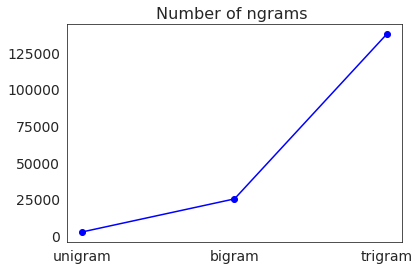

In [50]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams ', {'fontsize':16})
plt.show()

In [51]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)

In [52]:
X_tr_bow = bow_transform.fit_transform(training_data['text'])

In [53]:
len(bow_transform.vocabulary_)

110203

In [54]:
X_tr_bow.shape

(7000, 110203)

In [55]:
X_te_bow = bow_transform.transform(test_data['text'])

#### Tf-Idf

In [56]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [57]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

# Modelo

In [72]:
# se crea un dataframe en el que se guardan los resultados de los modelos
df_results = pd.DataFrame()

## ??

## knn

In [73]:
param_grid_ = {"algorithm":["ball_tree", "kd_tree"], "leaf_size":[3, 10, 33, 100], "n_neighbors":[3, 10, 33, 100]}
neigh = KNeighborsClassifier()

bow_search = GridSearchCV(neigh, cv=5, param_grid=param_grid_,  n_jobs = -1)
tfidf_search = GridSearchCV(neigh, cv=5, param_grid=param_grid_,  n_jobs = -1)
bow_search.fit(X_tr_bow, y_tr)
tfidf_search.fit(X_tr_tfidf, y_tr)

/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/ju

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'leaf_size': [3, 10, 33, 100],
                         'n_neighbors': [3, 10, 33, 100]})

In [74]:
bow_search.best_params_

{'algorithm': 'ball_tree', 'leaf_size': 3, 'n_neighbors': 100}

In [75]:
tfidf_search.best_params_

{'algorithm': 'ball_tree', 'leaf_size': 3, 'n_neighbors': 3}

In [76]:
knn_model_bow = KNeighborsClassifier(algorithm='ball_tree',
                                     leaf_size=3,
                                     n_neighbors=100).fit(X_tr_bow, y_tr)
knn_model_tfidf = KNeighborsClassifier(algorithm='ball_tree',
                                     leaf_size=3,
                                     n_neighbors=3).fit(X_tr_tfidf, y_tr)

In [77]:
y_pred_train = knn_model_bow.predict(X_tr_bow)
y_pred_test = knn_model_bow.predict(X_te_bow)

print("---------------- BOW ----------------")
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_tr, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_te, y_pred_test))
print(classification_report(y_te, y_pred_test))

precision, recall, fscore, _ = score(y_te, y_pred_test)

new_data = pd.DataFrame({'Modelo': ['KNN BOW'],
                         'label':  ['Negativo'],
                         'F1 score': [fscore[0]],
                         'precision': [precision[0]],
                         'recall': [recall[0]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['KNN BOW'],
                         'label':  ['Nulo'],
                         'F1 score': [fscore[1]],
                         'precision': [precision[1]],
                         'recall': [recall[1]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['KNN BOW'],
                         'label':  ['Positivo'],
                         'F1 score': [fscore[2]],
                         'precision': [precision[2]],
                         'recall': [recall[2]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)

y_pred_train = knn_model_tfidf.predict(X_tr_tfidf)
y_pred_test = knn_model_tfidf.predict(X_te_tfidf)

print("---------------- TFIDF ----------------")
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_tr, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_te, y_pred_test))
print(classification_report(y_te, y_pred_test))

precision, recall, fscore, _ = score(y_te, y_pred_test)

new_data = pd.DataFrame({'Modelo': ['KNN TFIDF'],
                         'label':  ['Negativo'],
                         'F1 score': [fscore[0]],
                         'precision': [precision[0]],
                         'recall': [recall[0]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['KNN TFIDF'],
                         'label':  ['Nulo'],
                         'F1 score': [fscore[1]],
                         'precision': [precision[1]],
                         'recall': [recall[1]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['KNN TFIDF'],
                         'label':  ['Positivo'],
                         'F1 score': [fscore[2]],
                         'precision': [precision[2]],
                         'recall': [recall[2]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)

---------------- BOW ----------------
Exactitud sobre entrenamiento: 0.37
Exactitud sobre test: 0.35
              precision    recall  f1-score   support

        -1.0       0.35      0.23      0.28       974
         0.0       0.34      0.56      0.43       998
         1.0       0.38      0.28      0.32      1028

    accuracy                           0.36      3000
   macro avg       0.36      0.35      0.34      3000
weighted avg       0.36      0.35      0.34      3000

---------------- TFIDF ----------------
Exactitud sobre entrenamiento: 0.64
Exactitud sobre test: 0.36
              precision    recall  f1-score   support

        -1.0       0.34      0.29      0.31       974
         0.0       0.52      0.11      0.19       998
         1.0       0.36      0.67      0.47      1028

    accuracy                           0.36      3000
   macro avg       0.40      0.36      0.32      3000
weighted avg       0.40      0.36      0.32      3000



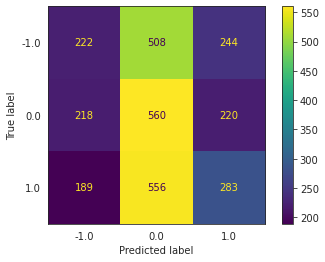

In [78]:
# Se puede visualizar la matriz de confusión
confusion_matrix(y_te, y_pred_test)
plot_confusion_matrix(knn_model_bow, X_te_bow, y_te)  
plt.show()

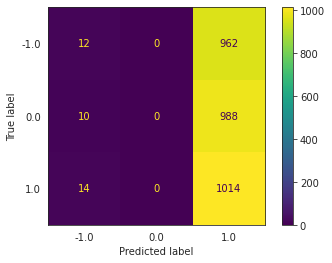

In [79]:
# Se puede visualizar la matriz de confusión
confusion_matrix(y_te, y_pred_test)
plot_confusion_matrix(knn_model_tfidf, X_te_bow, y_te)  
plt.show()

## SVM

In [80]:
param_grid_ = {"kernel":["poly"], "degree":[3, 10, 33]}
SVM = svm.SVC(random_state=0)

bow_search = GridSearchCV(SVM, cv=5, param_grid=param_grid_, n_jobs = -1, verbose = 5)
tfidf_search = GridSearchCV(SVM, cv=5, param_grid=param_grid_, n_jobs = -1, verbose = 5)
bow_search.fit(X_tr_bow, y_tr)
tfidf_search.fit(X_tr_tfidf, y_tr)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/ju

[CV 2/5] END ............degree=10, kernel=poly;, score=0.348 total time=  57.5s
[CV 2/5] END .............degree=3, kernel=poly;, score=0.367 total time=  54.7s
[CV 5/5] END ............degree=10, kernel=poly;, score=0.352 total time=  45.6s


/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/ju

[CV 1/5] END ............degree=10, kernel=poly;, score=0.359 total time=  54.6s
[CV 4/5] END ............degree=10, kernel=poly;, score=0.353 total time=  49.9s


/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/juan/.pyenv/versions/3.8.9/envs/universidad/lib/python3.8/site-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/ju

KeyboardInterrupt: 

In [ ]:
bow_search.best_params_

In [60]:
svm_model_bow = svm.SVC(kernel="rbf", degree=3).fit(X_tr_bow, y_tr)

In [ ]:
tfidf_search.best_params_

In [ ]:
svm_model_tfidf = SVC(kernel="poly", degree=10).fit(X_tr_tfidf, y_tr)

In [65]:
y_pred_train = svm_model_bow.predict(X_tr_bow)
y_pred_test = svm_model_bow.predict(X_te_bow)

print("---------------- BOW ----------------")
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_tr, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_te, y_pred_test))
print(classification_report(y_te, y_pred_test))

precision, recall, fscore, _ = score(y_te, y_pred_test)

new_data = pd.DataFrame({'Modelo': ['SVM BOW'],
                         'label':  ['Negativo'],
                         'F1 score': [fscore[0]],
                         'precision': [precision[0]],
                         'recall': [recall[0]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['SVM BOW'],
                         'label':  ['Nulo'],
                         'F1 score': [fscore[1]],
                         'precision': [precision[1]],
                         'recall': [recall[1]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['SVM BOW'],
                         'label':  ['Positivo'],
                         'F1 score': [fscore[2]],
                         'precision': [precision[2]],
                         'recall': [recall[2]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)

y_pred_train = svm_model_tfidf.predict(X_tr_tfidf)
y_pred_test = svm_model_tfidf.predict(X_te_tfidf)

print("---------------- TFIDF ----------------")
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_tr, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_te, y_pred_test))
print(classification_report(y_te, y_pred_test))

precision, recall, fscore, _ = score(y_te, y_pred_test)

new_data = pd.DataFrame({'Modelo': ['SVM TFIDF'],
                         'label':  ['Negativo'],
                         'F1 score': [fscore[0]],
                         'precision': [precision[0]],
                         'recall': [recall[0]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['SVM TFIDF'],
                         'label':  ['Nulo'],
                         'F1 score': [fscore[1]],
                         'precision': [precision[1]],
                         'recall': [recall[1]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)
new_data = pd.DataFrame({'Modelo': ['SVM TFIDF'],
                         'label':  ['Positivo'],
                         'F1 score': [fscore[2]],
                         'precision': [precision[2]],
                         'recall': [recall[2]],
                        })
df_results = pd.concat([df_results, new_data], ignore_index = True, axis = 0)

---------------- BOW ----------------
Exactitud sobre entrenamiento: 0.89
Exactitud sobre test: 0.40
              precision    recall  f1-score   support

        -1.0       0.30      0.25      0.27        91
         0.0       0.45      0.31      0.37        99
         1.0       0.43      0.60      0.50       110

    accuracy                           0.40       300
   macro avg       0.39      0.39      0.38       300
weighted avg       0.40      0.40      0.39       300



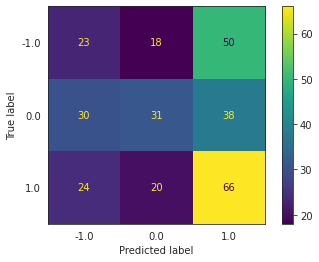

In [66]:
# Se puede visualizar la matriz de confusión
confusion_matrix(y_te, y_pred_test)
plot_confusion_matrix(svm_model_bow, X_te_bow, y_te)  
plt.show()

In [ ]:
# Se puede visualizar la matriz de confusión
confusion_matrix(y_te, y_pred_test)
plot_confusion_matrix(svm_model_tfidf, X_te_tfidf, y_te)  
plt.show()

# Interpretación y analisis de resultados

Se muestran graficas en las que se puede comparar el resultado obtenido para cada uno de los modelos implementados, asi se puede elegir el modelo con mayor desempeño

In [67]:
df_results

,Modelo,label,F1 score,precision,recall
0,SVM,Negativo,0.273810,0.298701,0.252747
1,SVM,Nulo,0.369048,0.449275,0.313131
2,SVM,Positivo,0.500000,0.428571,0.600000


<AxesSubplot:xlabel='Modelo', ylabel='recall'>

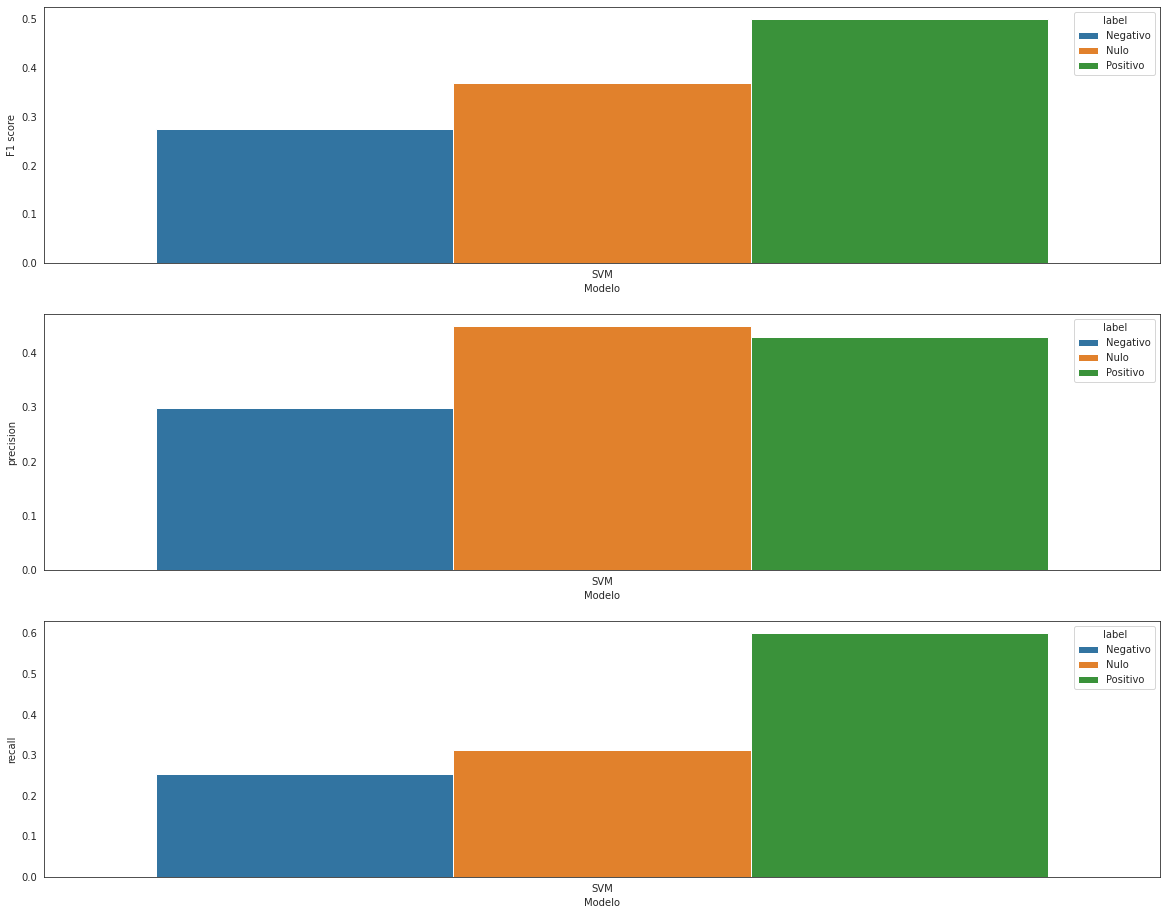

In [68]:
fig, axes = plt.subplots(3, 1, figsize=(20,16))
sns.barplot(x="Modelo", y="F1 score", hue='label', data=df_results, ax=axes[0])
sns.barplot(x="Modelo", y="precision", hue='label', data=df_results, ax=axes[1])
sns.barplot(x="Modelo", y="recall", hue='label', data=df_results, ax=axes[2])

# Modelo final

# Conslusiones y recomendaciones